# Sample Bias 1D

<div class="btn btn-notebook" role="button">
    <img src="../_static/images/colab_logo_32px.png"> [Run in Google Colab](https://colab.research.google.com/drive/1Hbg2kDXKjKzeQKJSwxzaV7pwbmORhyA3?usp=sharing)
</div>
<div class="btn btn-notebook" role="button">
    <img src="../_static/images/github_logo_32px.png"> [View on GitHub](https://github.com/adapt-python/adapt/blob/master/docs/examples/sample_bias.ipynb)
</div>

The following example is a 1D regression domain adaptation issue. The goal is to learn the regression task on the target data (orange points) knowing only the labels on the source data (blue points). 

In this example, there is a sample bias between the source and target datasets. The sources are drawn according to a gaussian distribution whereas the targets are uniformly distributed.

The following methods are being tested:

- [Source Only](#Source-Only)
- [KMM](#KMM)
- [KLIEP](#KLIEP)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics.pairwise import rbf_kernel
from adapt.instance_based import KMM, KLIEP
from adapt.feature_based import CORAL, DeepCORAL, DANN, mSDA

## Setup

In [2]:
def f(x, noise=0.1):
    return (x ** 4) * np.exp(-x**2) + (x**2) * (1 - np.exp(-x**2)) + noise * np.random.randn(len(x))

def gaussian(x, s=0.5):
    return 1./np.sqrt( 2. * np.pi * s**2 ) * np.exp( -x**2 / ( 2. * s**2 ) )

np.random.seed(0)
lin = np.linspace(-1.6, 1.6, 100)
Xs = np.random.randn(100) * 0.5
Xt = np.random.random(100) * 3 - 1.5
ys = f(Xs)
yt = f(Xt)

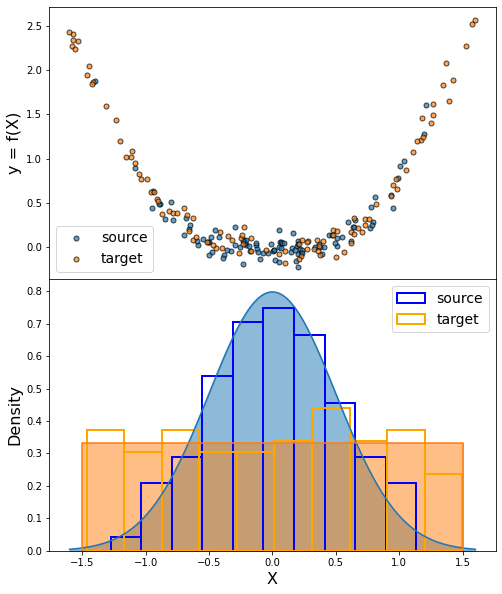

In [3]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

ax1.plot(Xs, ys, '.', label="source", ms=10, alpha=0.7, markeredgecolor="black")
ax1.plot(Xt, yt, '.', label="target", ms=10, alpha=0.7, markeredgecolor="black")
ax2.hist(Xs, density=True, edgecolor='blue', label="source", fc=(0., 0, 0, 0.), lw=2)
ax2.hist(Xt, density=True, edgecolor='orange', label="target", fc=(0., 0, 0, 0.), lw=2)
ax2.plot(lin, gaussian(lin), color="C0")
ax2.fill_between(lin, gaussian(lin), alpha=0.5, color="C0")
ax2.plot([-1.5, -1.5, 1.5, 1.5], [0, 1/3., 1/3., 0.], color="C1")
ax2.fill_between([-1.5, -1.5, 1.5, 1.5], [0, 1/3., 1/3., 0.], alpha=0.5, color="C1")

ax1.legend(fontsize=14)
ax2.legend(fontsize=14)

ax2.set_xlabel("X", fontsize=16)

ax1.set_ylabel("y = f(X)", fontsize=16)
ax2.set_ylabel("Density", fontsize=16)

plt.subplots_adjust(hspace=0.)

## Source Only

In [4]:
np.random.seed(0)
estimator = MLPRegressor((100, 100))
estimator.fit(Xs.reshape(-1,1), f(Xs));

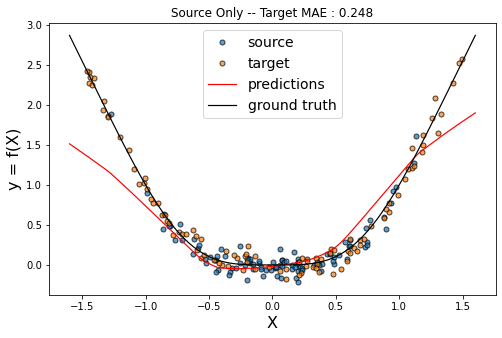

In [5]:
yp_lin = estimator.predict(lin.reshape(-1, 1))

score = mean_absolute_error(estimator.predict(Xt.reshape(-1, 1)).ravel(), yt)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.plot(Xs, ys, '.', label="source", ms=10, alpha=0.7, markeredgecolor="black")
ax.plot(Xt, yt, '.', label="target", ms=10, alpha=0.7, markeredgecolor="black")
ax.plot(lin, yp_lin, label="predictions", lw=1.2, color="red")
ax.plot(lin, f(lin, 0), label="ground truth", lw=1.2, color="black")

ax.legend(fontsize=14)
ax.set_xlabel("X", fontsize=16)
ax.set_ylabel("y = f(X)", fontsize=16)
ax.set_title("Source Only -- Target MAE : %.3f"%score)

plt.show()

## [KMM](../generated/adapt.instance_based.KMM.html)

In [6]:
np.random.seed(0)
estimator = MLPRegressor((100, 100))
kmm = KMM(estimator, kernel_params=dict(gamma=0.1), random_state=0)
kmm.fit(Xs, ys, Xt);

Fitting weights...
     pcost       dcost       gap    pres   dres
 0:  4.7447e+04 -7.7223e+05  3e+07  4e-01  1e-15
 1: -1.3351e+02 -2.6366e+05  3e+05  1e-03  3e-13
 2: -1.8642e+02 -2.0333e+04  2e+04  2e-05  2e-14
 3: -4.7934e+02 -1.8983e+04  2e+04  1e-05  1e-14
 4: -4.3560e+03 -2.3704e+04  2e+04  3e-16  4e-16
 5: -4.3665e+03 -4.9080e+03  5e+02  2e-16  2e-16
 6: -4.3757e+03 -4.5211e+03  1e+02  2e-16  2e-16
 7: -4.3851e+03 -4.4686e+03  8e+01  1e-16  2e-16
 8: -4.3854e+03 -4.3884e+03  3e+00  2e-16  2e-16
 9: -4.3854e+03 -4.3855e+03  4e-02  2e-16  2e-16
10: -4.3854e+03 -4.3854e+03  2e-03  2e-16  2e-16
Optimal solution found.
Fitting estimator...


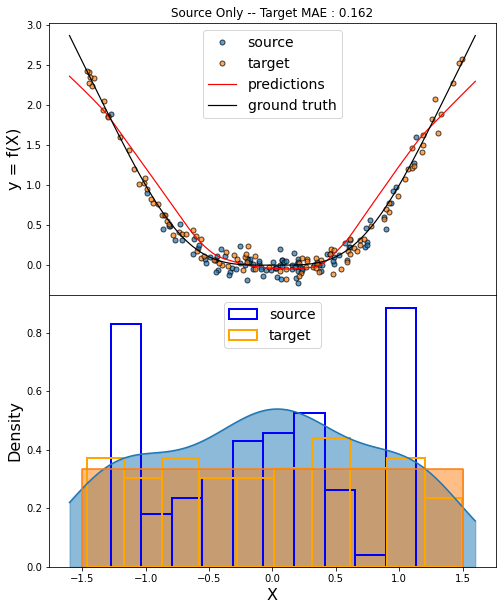

In [7]:
np.random.seed(0)
yp_lin = kmm.predict(lin.reshape(-1, 1))
score = mean_absolute_error(kmm.predict(Xt.reshape(-1, 1)).ravel(), yt)

weights = kmm.predict_weights()
Xs_weighted = np.random.choice(Xs, 3 * len(Xs), p=weights / weights.sum())
kde = rbf_kernel(lin.reshape(-1, 1), Xs_weighted.reshape(-1,1), gamma=3.).sum(1)
kde /= kde.sum()
kde *= 40.

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

ax1.plot(Xs, ys, '.', label="source", ms=10, alpha=0.7, markeredgecolor="black")
ax1.plot(Xt, yt, '.', label="target", ms=10, alpha=0.7, markeredgecolor="black")
ax1.plot(lin, yp_lin, label="predictions", lw=1.2, color="red")
ax1.plot(lin, f(lin, 0), label="ground truth", lw=1.2, color="black")

ax2.hist(Xs_weighted, density=True, edgecolor='blue', label="source", fc=(0., 0, 0, 0.), lw=2)
ax2.hist(Xt, density=True, edgecolor='orange', label="target", fc=(0., 0, 0, 0.), lw=2)
ax2.plot(lin, kde, color="C0")
ax2.fill_between(lin, kde, alpha=0.5, color="C0")
ax2.plot([-1.5, -1.5, 1.5, 1.5], [0, 1/3., 1/3., 0.], color="C1")
ax2.fill_between([-1.5, -1.5, 1.5, 1.5], [0, 1/3., 1/3., 0.], alpha=0.5, color="C1")

ax1.legend(fontsize=14)
ax2.legend(fontsize=14)

ax2.set_xlabel("X", fontsize=16)

ax1.set_ylabel("y = f(X)", fontsize=16)
ax2.set_ylabel("Density", fontsize=16)

plt.subplots_adjust(hspace=0.)

ax1.set_title("Source Only -- Target MAE : %.3f"%score)

plt.show()

## [KLIEP](../generated/adapt.instance_based.KLIEP.html)

In [8]:
np.random.seed(0)
estimator = MLPRegressor((100, 100))
kliep = KLIEP(estimator, sigmas=[0.001, 0.01, 0.1, 0.5, 1., 2., 5.], random_state=0)
kliep.fit(Xs, ys, Xt);

Fitting weights...
Cross Validation process...
Parameter sigma = 0.0010 -- J-score = -0.000 (0.000)
Parameter sigma = 0.0100 -- J-score = -0.005 (0.002)
Parameter sigma = 0.1000 -- J-score = -0.044 (0.015)
Parameter sigma = 0.5000 -- J-score = 0.003 (0.011)
Parameter sigma = 1.0000 -- J-score = 0.114 (0.014)
Parameter sigma = 2.0000 -- J-score = 0.236 (0.035)
Parameter sigma = 5.0000 -- J-score = 0.349 (0.090)
Fitting estimator...


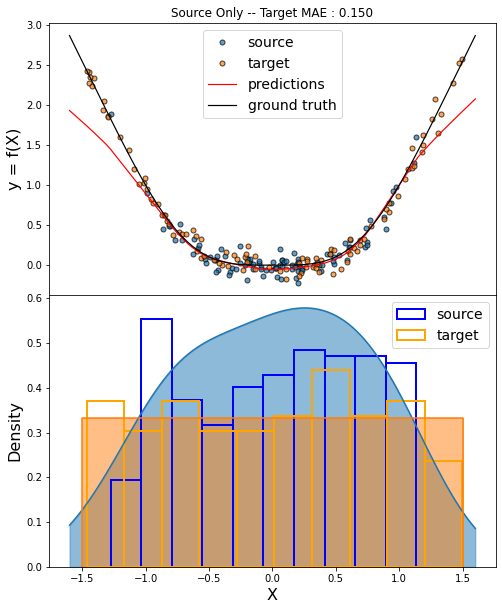

In [9]:
np.random.seed(0)
yp_lin = kliep.predict(lin.reshape(-1, 1))
score = mean_absolute_error(kliep.predict(Xt.reshape(-1, 1)).ravel(), yt)

weights = kliep.predict_weights()
Xs_weighted = np.random.choice(Xs, 3 * len(Xs), p=weights / weights.sum())
kde = rbf_kernel(lin.reshape(-1, 1), Xs_weighted.reshape(-1,1), gamma=3.).sum(1)
kde /= kde.sum()
kde *= 40.

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

ax1.plot(Xs, ys, '.', label="source", ms=10, alpha=0.7, markeredgecolor="black")
ax1.plot(Xt, yt, '.', label="target", ms=10, alpha=0.7, markeredgecolor="black")
ax1.plot(lin, yp_lin, label="predictions", lw=1.2, color="red")
ax1.plot(lin, f(lin, 0), label="ground truth", lw=1.2, color="black")

ax2.hist(Xs_weighted, density=True, edgecolor='blue', label="source", fc=(0., 0, 0, 0.), lw=2)
ax2.hist(Xt, density=True, edgecolor='orange', label="target", fc=(0., 0, 0, 0.), lw=2)
ax2.plot(lin, kde, color="C0")
ax2.fill_between(lin, kde, alpha=0.5, color="C0")
ax2.plot([-1.5, -1.5, 1.5, 1.5], [0, 1/3., 1/3., 0.], color="C1")
ax2.fill_between([-1.5, -1.5, 1.5, 1.5], [0, 1/3., 1/3., 0.], alpha=0.5, color="C1")

ax1.legend(fontsize=14)
ax2.legend(fontsize=14)

ax2.set_xlabel("X", fontsize=16)

ax1.set_ylabel("y = f(X)", fontsize=16)
ax2.set_ylabel("Density", fontsize=16)

plt.subplots_adjust(hspace=0.)

ax1.set_title("Source Only -- Target MAE : %.3f"%score)

plt.show()